<center><b>  <span style="font-size:24px;">FINA 4335 -Final Project-<span style="color:red;">Part II <span></span></b>
<center><span style="font-size:22px;"><b>Due date: 12/11/2024 11:59 PM ET</b></span></center>
            
##### First name and Last name (team member 1): Stephen Magliocchino
##### First name and Last name (team member 2): Benjamin Damon
##### First name and Last name (team member 3): Benjamin Inglesby

## Instructions
1. Please rename the notebook. It should have the following format: **Final Project_Part II_Lastname1_Lastname2** if there are 2 members in the team.
1. Use this **template** and you are free to add more code/markdown cells. Change the markdown cells if necessary. Well format this notebook file.
1. After you answer all questions:
    1. Restart your kernel and run all cells
    1. Save your notebook and export your notebook as HTML
    1. Submit the **notebook** and **HTML** to Canvas, under Final Group Project.

## Some Grading Guidelines
1. All code cells (excluding evaluation cells) should be **executable**. 
    - Non-executable code cells will receive up to **50%** of grade deduction. To receive more partial credit for a non-executable code cell, ensure it includes sufficient comments.
1.  <span style="color: blue;">I grade on both **correctness** and **effort**</span>
    - **Suppose you don’t know how to generate a specific variable, then you <span style="color: red;">may use random values (with somewhat reasonable range) to replace the variable</span>. You will lose point for that variable but will get most credit for subsequent questions.**
1. Write efficient and clean code
    -  No repetitive code (An example of repetitive code: import the same csv file twice).
    - Informative variable names (if not specified in the project description).
    - Less than 2 uncommented `print`, `.describe()`, or similar quality check in every code cell or every 5 lines of code.
    - Every 2 occurrence of inefficient or inclean code will receive **1 point deduction**
1. Preserve as many observations as possible
    - Losing observations is considered partially incorrect code
    - Do not fill NAs
1. Include sufficient comments (at least 1 comment every 3 lines of code)
      - Failure to include sufficient comments will result in a **5 points** grade deduction
1. Format the markdown file such as including headings and brief question description
1. Use the methods and formulas **covered in the lecture notebooks**. Using formulas inconsistent to the lecture notebooks receives 20% of grade penalty
1. Reasonable code execution time
   - The code execution time for this Part should be less than 20 minutes, otherwise **deduct 1 point for every 5 minutes more code execuation time**
1. **10% of grade penalty per day late, receive 0% if the project is submitted after Dec 13 11:59 PM ET.**

In [319]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import scipy.stats as stats 
import statsmodels.api as sm
import pandas_datareader.data as web
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time
%config InlineBackend.figure_format = 'retina'
# Measure execution time
start_time_part2 = time.time()  # Start time

## Data preparation (5 points)
**Explanation of variables in 'weekly_rets.csv'**

- **DATE**: This variable represents the last trading day of each week.
- **PERMNO**: This is a unique identifier assigned to each security.
- **ret**: the stock's weekly return, expressed as a decimal.
  
**Explanation of variables in 'monthly_rets_funda.csv'**

- **DATE**: This variable represents the last trading day of each month.
- **PERMNO**: This is a unique identifier assigned to each security.
- **PRC**: reflects the **unadjusted** close price of a stock on the last trading day of the month. This value is the raw closing price without adjustments for corporate actions such as stock splits, dividends, or other modifications.
- **RET**: the stock's monthly return, expressed as a decimal. 
- **SHROUT**: The **shares outstanding** (SHROUT) variable represents the number of shares (in thousands) of a company’s stock that are currently held by all shareholders.
- **revenues**:  This variable represents the total revenues for a specific fiscal year. The variable is already 'lagged'.

In [320]:
# Write your code in the provided code cell; you can add more cells (same applies below, no further repetition).
weekly_rets = pd.read_csv('weekly_rets.csv', parse_dates=['DATE'])
monthly_rets = pd.read_csv('monthly_rets_funda.csv', parse_dates=['DATE'])
weekly_rets.sort_values(by=['PERMNO', 'DATE'], inplace=True)
monthly_rets.sort_values(by=['PERMNO', 'DATE'], inplace=True)
mrets_with_signals = monthly_rets.copy()

In [321]:
# Evaluation cell (used for grading-I don't have a TA)
# you don't need to worry at all if you think certain valuation cell is wrong (same applies below, no further repetition)
print(weekly_rets.head())
print(monthly_rets.head())

        DATE  PERMNO       ret
0 2008-01-04   10001 -0.028264
1 2008-01-11   10001 -0.013150
2 2008-01-18   10001 -0.004682
3 2008-01-25   10001  0.002904
4 2008-02-01   10001  0.026923
        DATE  PERMNO        PRC       RET    SHROUT  revenues
0 2008-01-31   10001  13.986000 -0.006076  2872.125    84.278
1 2008-02-29   10001   9.490400  0.021682  4340.655    84.278
2 2008-03-31   10001   8.956035 -0.052463  4342.653    84.278
3 2008-04-30   10001   8.591400 -0.036661  4342.653    84.278
4 2008-05-30   10001  10.889100  0.271356  4342.653    84.278


## Constructing factors (33 points; 15+8+5+5)

### Create signals  (3*5=15 points)

#### price_to_sales

In [322]:
# revenue is already 'lagged'
mrets_with_signals['price_to_sales'] = mrets_with_signals['PRC'] / mrets_with_signals['revenues']

In [323]:
# some quality check such as .describe() and print head of key variables
print(mrets_with_signals.describe())
print(mrets_with_signals.isnull().sum())
print(mrets_with_signals.head())

                                DATE         PERMNO            PRC  \
count                         527919  527919.000000  525406.000000   
mean   2015-12-02 04:09:19.313076224   58495.690371      37.219174   
min              2008-01-31 00:00:00   10001.000000       0.016983   
25%              2011-09-30 00:00:00   18838.000000       5.154840   
50%              2015-10-30 00:00:00   76750.000000      17.032950   
75%              2020-01-31 00:00:00   87377.000000      41.308650   
max              2023-12-29 00:00:00   93436.000000    6993.449750   
std                              NaN   32011.164148     109.502017   

                 RET        SHROUT       revenues  price_to_sales  
count  525388.000000  5.279190e+05  505997.000000   503601.000000  
mean        0.009336  1.336051e+05    4137.744604        1.843115  
min        -0.971201  8.991000e+00   -1964.999000     -165.275735  
25%        -0.072681  1.954144e+04      91.016000        0.010764  
50%         0.002023  4.20619

#### ret_2to12m

In [324]:
# Each signal is only worth 3 points. Suppose you don’t know how to generate a specific signal, then you may use random values 
# (with somewhat reasonable range) to replace the signal. You will lose 3 points but will get most credit for subsequent questions.
mrets_with_signals['ret_2to12m'] = (1 + mrets_with_signals['RET']).shift(2) * (1 + mrets_with_signals['RET']).shift(12) - 1

In [325]:
# some quality check such as .describe() and print head of key variables



#### ret_2w

In [326]:
# Each signal is only worth 3 points. Suppose you don’t know how to generate a specific signal, then you may use random values 
# (with somewhat reasonable range) to replace the signal. You will lose 3 points but will get most credit for subsequent questions.

temp_weekly_rets = weekly_rets.copy(deep=True)
# Ensure ret column exists in weekly_rets
temp_weekly_rets['ret'] = temp_weekly_rets['ret'].fillna(0)  # Replace NaNs with 0 for safe return calculations

# Calculate ret_2w for each PERMNO
temp_weekly_rets['ret_2w'] = (1 + temp_weekly_rets['ret']).shift(1) * (1 + temp_weekly_rets['ret']).shift(2) - 1

# Merge ret_2w into mrets_with_signals
mrets_with_signals = mrets_with_signals.merge(
    temp_weekly_rets[['PERMNO', 'DATE', 'ret_2w']],
    on=['PERMNO', 'DATE'],
    how='left'
)

print(mrets_with_signals.head())


        DATE  PERMNO        PRC       RET    SHROUT  revenues  price_to_sales  \
0 2008-01-31   10001  13.986000 -0.006076  2872.125    84.278        0.165951   
1 2008-02-29   10001   9.490400  0.021682  4340.655    84.278        0.112608   
2 2008-03-31   10001   8.956035 -0.052463  4342.653    84.278        0.106268   
3 2008-04-30   10001   8.591400 -0.036661  4342.653    84.278        0.101941   
4 2008-05-30   10001  10.889100  0.271356  4342.653    84.278        0.129205   

   ret_2to12m    ret_2w  
0         NaN       NaN  
1         NaN -0.029025  
2         NaN       NaN  
3         NaN       NaN  
4         NaN  0.170767  


In [327]:
# some quality check such as .describe() and print head of key variables
print(mrets_with_signals.dropna().shape)
print(mrets_with_signals.shape)


(223675, 9)
(527919, 9)


#### mcap_quarter

In [328]:
# Each signal is only worth 3 points. Suppose you don’t know how to generate a specific signal, then you may use random values 
# (with somewhat reasonable range) to replace the signal. You will lose 3 points but will get most credit for subsequent questions.
mrets_with_signals['mcap_quarter'] = mrets_with_signals['PRC'] * mrets_with_signals['SHROUT']

In [329]:
# some quality check such as .describe() and print head of key variables
print(mrets_with_signals.describe())
print(mrets_with_signals.isnull().sum())
print(mrets_with_signals.head())

                                DATE         PERMNO            PRC  \
count                         527919  527919.000000  525406.000000   
mean   2015-12-02 04:09:19.313076224   58495.690371      37.219174   
min              2008-01-31 00:00:00   10001.000000       0.016983   
25%              2011-09-30 00:00:00   18838.000000       5.154840   
50%              2015-10-30 00:00:00   76750.000000      17.032950   
75%              2020-01-31 00:00:00   87377.000000      41.308650   
max              2023-12-29 00:00:00   93436.000000    6993.449750   
std                              NaN   32011.164148     109.502017   

                 RET        SHROUT       revenues  price_to_sales  \
count  525388.000000  5.279190e+05  505997.000000   503601.000000   
mean        0.009336  1.336051e+05    4137.744604        1.843115   
min        -0.971201  8.991000e+00   -1964.999000     -165.275735   
25%        -0.072681  1.954144e+04      91.016000        0.010764   
50%         0.002023  4.

#### beta

In [330]:
temp_weekly_rets = weekly_rets.copy(deep=True)
temp_weekly_rets['market_ret'] = temp_weekly_rets['ret']  # Replace this with actual market proxy

# Calculate rolling beta for each PERMNO over a 52-week window
def calculate_beta(group):
    # Covariance and variance rolling calculations
    rolling_cov = group['ret'].rolling(window=52, min_periods=24).cov(group['market_ret'])
    rolling_var = group['market_ret'].rolling(window=52, min_periods=24).var()
    return rolling_cov / rolling_var

# Add beta to weekly_rets
temp_weekly_rets['beta'] = temp_weekly_rets.groupby('PERMNO').apply(calculate_beta).reset_index(level=0, drop=True)

# Merge beta into mrets_with_signals
mrets_with_signals = mrets_with_signals.merge(
    temp_weekly_rets[['PERMNO', 'DATE', 'beta']],
    on=['PERMNO', 'DATE'],
    how='left'
)


In [331]:
# some quality check such as .describe() and print head of key variables

mrets_with_signals["beta"].value_counts()

beta
1.0    19932
1.0    16985
1.0    12745
1.0    11432
1.0     9051
       ...  
1.0        1
1.0        1
1.0        1
1.0        1
1.0        1
Name: count, Length: 798, dtype: int64

In [332]:
print(mrets_with_signals.dropna().shape)
print(mrets_with_signals.shape)


(219097, 11)
(527919, 11)


In [333]:
#############################################################################################################################
# Evaluation cell (used for grading-I don't have a TA)
#############################################################################################################################
some_vars = ['PERMNO','RET']+['price_to_sales', 'ret_2to12m', 'ret_2w', 'mcap_quarter', 'beta']
print(mrets_with_signals[some_vars].head())
mrets_with_signals[some_vars].describe()

   PERMNO       RET  price_to_sales  ret_2to12m    ret_2w  mcap_quarter  beta
0   10001 -0.006076        0.165951         NaN       NaN  40169.540250   NaN
1   10001  0.021682        0.112608         NaN -0.029025  41194.552646   NaN
2   10001 -0.052463        0.106268         NaN       NaN  38892.952261   NaN
3   10001 -0.036661        0.101941         NaN       NaN  37309.468984   NaN
4   10001  0.271356        0.129205         NaN  0.170767  47287.582782   NaN


,PERMNO,RET,price_to_sales,ret_2to12m,ret_2w,mcap_quarter,beta
count,527919.000000,525388.000000,503601.000000,522860.000000,235726.000000,5.254060e+05,2.295620e+05
mean,58495.690371,0.009336,1.843115,0.019139,-0.000126,7.108534e+06,1.000000e+00
std,32011.164148,0.198896,150.352424,0.282257,0.128383,4.409977e+07,4.796130e-15
min,10001.000000,-0.971201,-165.275735,-0.972863,-0.954480,8.815842e+01,1.000000e+00
25%,18838.000000,-0.072681,0.010764,-0.109700,-0.046809,1.246557e+05,1.000000e+00
50%,76750.000000,0.002023,0.033545,0.004346,0.000328,6.304427e+05,1.000000e+00
75%,87377.000000,0.074546,0.106009,0.116126,0.043689,2.908814e+06,1.000000e+00
max,93436.000000,17.587045,34545.420000,25.258856,7.593169,3.065205e+09,1.000000e+00


In [334]:
# Evaluation cell (used for grading-I don't have a TA)
mrets_with_signals.head()

,DATE,PERMNO,PRC,RET,SHROUT,revenues,price_to_sales,ret_2to12m,ret_2w,mcap_quarter,beta
0,2008-01-31,10001,13.986000,-0.006076,2872.125,84.278,0.165951,NaN,NaN,40169.540250,NaN
1,2008-02-29,10001,9.490400,0.021682,4340.655,84.278,0.112608,NaN,-0.029025,41194.552646,NaN
2,2008-03-31,10001,8.956035,-0.052463,4342.653,84.278,0.106268,NaN,NaN,38892.952261,NaN
3,2008-04-30,10001,8.591400,-0.036661,4342.653,84.278,0.101941,NaN,NaN,37309.468984,NaN
4,2008-05-30,10001,10.889100,0.271356,4342.653,84.278,0.129205,NaN,0.170767,47287.582782,NaN


### Form time-series portfolios (8 points) 

In [335]:
def calculate_quintile_portfolios(data, signal_col):
    """
    Calculate equal-weighted quintile portfolios and long-short factor.
    Args:
        data: DataFrame with `DATE`, `PERMNO`, `RET`, and signal_col.
        signal_col: The column name for the signal to form quintiles.
    Returns:
        DataFrame with quintile portfolio returns and long-short factor.
    """
    quintiles = []
    for date, group in data.groupby('DATE'):
        # Check if the group has enough unique values for quintiles
        if group[signal_col].nunique() < 5:
            print(f"Skipping {date}: Not enough unique values for quintiles.")
            continue

        try:
            # Assign quintiles based on the signal, dropping duplicate edges
            group['quintile'] = pd.qcut(group[signal_col], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')
        except ValueError as e:
            print(f"Error processing {date}: {e}")
            continue

        # Calculate equal-weighted returns for each quintile
        quintile_returns = group.groupby('quintile')['RET'].mean()
        quintile_returns['long_short'] = quintile_returns[5] - quintile_returns[1]

        # Store the result
        quintiles.append(pd.Series(quintile_returns, name=date))

    # Combine results into a single DataFrame
    quintile_df = pd.DataFrame(quintiles).sort_index()
    return quintile_df

In [336]:
# Signals to evaluate
signals = {
    'value': 'price_to_sales',
    'momentum': 'ret_2to12m',
    'reversal': 'ret_2w',
    'size': 'mcap_quarter',
    'beta': 'beta'
}

# Create DataFrames for each signal
results = {}
for signal_name, signal_col in signals.items():
    print(f"Processing signal: {signal_name}")
    results[f"{signal_name}_df"] = calculate_quintile_portfolios(mrets_with_signals, signal_col)


Processing signal: value
Processing signal: momentum
Processing signal: reversal
Skipping 2008-01-31 00:00:00: Not enough unique values for quintiles.
Skipping 2008-03-31 00:00:00: Not enough unique values for quintiles.
Skipping 2008-04-30 00:00:00: Not enough unique values for quintiles.
Skipping 2008-06-30 00:00:00: Not enough unique values for quintiles.
Skipping 2008-07-31 00:00:00: Not enough unique values for quintiles.
Skipping 2008-09-30 00:00:00: Not enough unique values for quintiles.
Skipping 2008-12-31 00:00:00: Not enough unique values for quintiles.
Skipping 2009-03-31 00:00:00: Not enough unique values for quintiles.
Skipping 2009-04-30 00:00:00: Not enough unique values for quintiles.
Skipping 2009-06-30 00:00:00: Not enough unique values for quintiles.
Skipping 2009-08-31 00:00:00: Not enough unique values for quintiles.
Skipping 2009-09-30 00:00:00: Not enough unique values for quintiles.
Skipping 2009-11-30 00:00:00: Not enough unique values for quintiles.
Skipping 

In [337]:
# Extract individual DataFrames
value_df = results['value_df']
momentum_df = results['momentum_df']
reversal_df = results['reversal_df']
size_df = results['size_df']
beta_df = results['beta_df']

# Display an example
print("Value Quintile Portfolio:")
print(value_df.head())

Value Quintile Portfolio:
quintile           1         2         3         4         5  long_short
2008-01-31 -0.049561 -0.065743 -0.073096 -0.062639 -0.069545   -0.019984
2008-02-29 -0.049509 -0.016020 -0.014834 -0.018725 -0.001499    0.048010
2008-03-31 -0.026643 -0.014588 -0.024092 -0.016265 -0.020581    0.006062
2008-04-30  0.018505  0.034605  0.028132  0.036749  0.053984    0.035478
2008-05-30  0.035554  0.040793  0.050799  0.054277  0.060336    0.024782


In [338]:
# Evaluation cell (used for grading-I don't have a TA)
print(value_df.head())
value_df.describe()

quintile           1         2         3         4         5  long_short
2008-01-31 -0.049561 -0.065743 -0.073096 -0.062639 -0.069545   -0.019984
2008-02-29 -0.049509 -0.016020 -0.014834 -0.018725 -0.001499    0.048010
2008-03-31 -0.026643 -0.014588 -0.024092 -0.016265 -0.020581    0.006062
2008-04-30  0.018505  0.034605  0.028132  0.036749  0.053984    0.035478
2008-05-30  0.035554  0.040793  0.050799  0.054277  0.060336    0.024782


quintile,1,2,3,4,5,long_short
count,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000
mean,-0.000985,0.006258,0.009194,0.013118,0.022433,0.023419
std,0.081211,0.069621,0.063282,0.059980,0.069310,0.046410
min,-0.338132,-0.253114,-0.233096,-0.183040,-0.177467,-0.170952
25%,-0.037451,-0.027466,-0.023212,-0.016997,-0.014859,0.002609
50%,0.001003,0.010098,0.013301,0.013583,0.020715,0.021186
75%,0.039544,0.042721,0.045138,0.050938,0.061435,0.046231
max,0.346708,0.264718,0.219045,0.193320,0.262614,0.190675


In [339]:
# Evaluation cell (do not change; used for grading)
print(momentum_df.head())
momentum_df.describe()

quintile           1         2         3         4         5  long_short
2008-01-31 -0.059215 -0.064957 -0.066439 -0.060199 -0.070431   -0.011216
2008-02-29 -0.016358 -0.011363 -0.030827 -0.021627 -0.016649   -0.000290
2008-03-31 -0.022779 -0.023053 -0.020062 -0.010672 -0.030363   -0.007583
2008-04-30  0.018690  0.030390  0.027208  0.044198  0.050444    0.031754
2008-05-30  0.056986  0.045831  0.061613  0.036648  0.038494   -0.018492


quintile,1,2,3,4,5,long_short
count,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000
mean,0.009814,0.010384,0.009983,0.009657,0.008920,-0.000894
std,0.087634,0.067174,0.059748,0.058486,0.069593,0.034107
min,-0.250730,-0.238441,-0.230443,-0.231296,-0.215790,-0.141938
25%,-0.034521,-0.024338,-0.020920,-0.021174,-0.024040,-0.016927
50%,0.011141,0.012918,0.014965,0.012833,0.010028,0.000550
75%,0.055250,0.044575,0.041766,0.045107,0.049203,0.018011
max,0.351078,0.244346,0.187476,0.182513,0.216267,0.101503


In [340]:
# Evaluation cell (used for grading-I don't have a TA)
print(reversal_df.head())
reversal_df.describe()

quintile           1         2         3         4         5  long_short
2008-02-29 -0.156090 -0.056181 -0.021829  0.010206  0.122714    0.278804
2008-05-30 -0.084904  0.010715  0.035984  0.079784  0.197571    0.282475
2008-08-29 -0.098958  0.000816  0.030897  0.054692  0.137004    0.235962
2008-10-31 -0.398328 -0.270059 -0.208815 -0.168071 -0.097994    0.300334
2008-11-28 -0.361555 -0.205324 -0.131903 -0.066269  0.042061    0.403616


quintile,1,2,3,4,5,long_short
count,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000
mean,-0.107855,-0.029438,0.003403,0.034088,0.135408,0.243263
std,0.079667,0.060994,0.054547,0.053887,0.086082,0.065918
min,-0.398328,-0.270059,-0.208815,-0.168071,-0.097994,-0.006824
25%,-0.139731,-0.056603,-0.024825,0.003078,0.085342,0.206498
50%,-0.089916,-0.013212,0.011570,0.035194,0.127646,0.227912
75%,-0.054056,0.013017,0.037224,0.068635,0.172451,0.278929
max,0.013222,0.053024,0.093469,0.148306,0.466733,0.493931


In [341]:
# Evaluation cell (used for grading-I don't have a TA)
print(size_df.head())
size_df.describe()

quintile           1         2         3         4         5  long_short
2008-01-31 -0.048869 -0.072163 -0.080454 -0.062854 -0.057342   -0.008473
2008-02-29 -0.017631 -0.036275 -0.028673 -0.016911 -0.001716    0.015915
2008-03-31 -0.082652 -0.034555  0.013776 -0.000874 -0.002543    0.080109
2008-04-30 -0.011354  0.022493  0.030700  0.054287  0.073322    0.084677
2008-05-30  0.021062  0.043675  0.054959  0.068040  0.051415    0.030354


quintile,1,2,3,4,5,long_short
count,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000
mean,-0.013990,0.012110,0.017062,0.017573,0.015828,0.029818
std,0.081728,0.078369,0.075312,0.064327,0.052205,0.053630
min,-0.275462,-0.256301,-0.238449,-0.207975,-0.180111,-0.193110
25%,-0.054907,-0.029763,-0.029529,-0.016045,-0.010059,0.004121
50%,-0.015803,0.011028,0.020997,0.022409,0.018991,0.033161
75%,0.027530,0.057313,0.060700,0.055461,0.046770,0.058263
max,0.268626,0.293462,0.287631,0.249626,0.168556,0.166313


In [342]:
# Evaluation cell (used for grading-I don't have a TA)
print(beta_df.head())
beta_df.describe()

quintile           1         2         3         4         5  long_short
2009-01-30 -0.023865 -0.023039 -0.030809 -0.008737 -0.032843   -0.008978
2009-02-27 -0.124877 -0.101805 -0.109806 -0.116103 -0.120832    0.004045
2009-05-29  0.103892  0.093197  0.132265  0.093712  0.077940   -0.025952
2009-07-31  0.091903  0.113208  0.109888  0.090813  0.100063    0.008160
2009-10-30 -0.056643 -0.062920 -0.060118 -0.063057 -0.046485    0.010159


quintile,1,2,3,4,5,long_short
count,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000
mean,0.008833,0.011730,0.017561,0.010374,0.008010,-0.000823
std,0.053220,0.059653,0.064037,0.056744,0.050897,0.007343
min,-0.124877,-0.130299,-0.125134,-0.116103,-0.120832,-0.025952
25%,-0.023847,-0.021231,-0.016466,-0.019474,-0.020522,-0.005531
50%,0.010337,0.009697,0.020956,0.011938,0.012251,0.000400
75%,0.046900,0.049156,0.058423,0.050789,0.042171,0.003761
max,0.103892,0.146546,0.183993,0.122662,0.100063,0.014839


### plot (5 points)

/var/folders/1b/vm9vwcxd62s4cvv71njdc7140000gv/T/ipykernel_85279/983609659.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


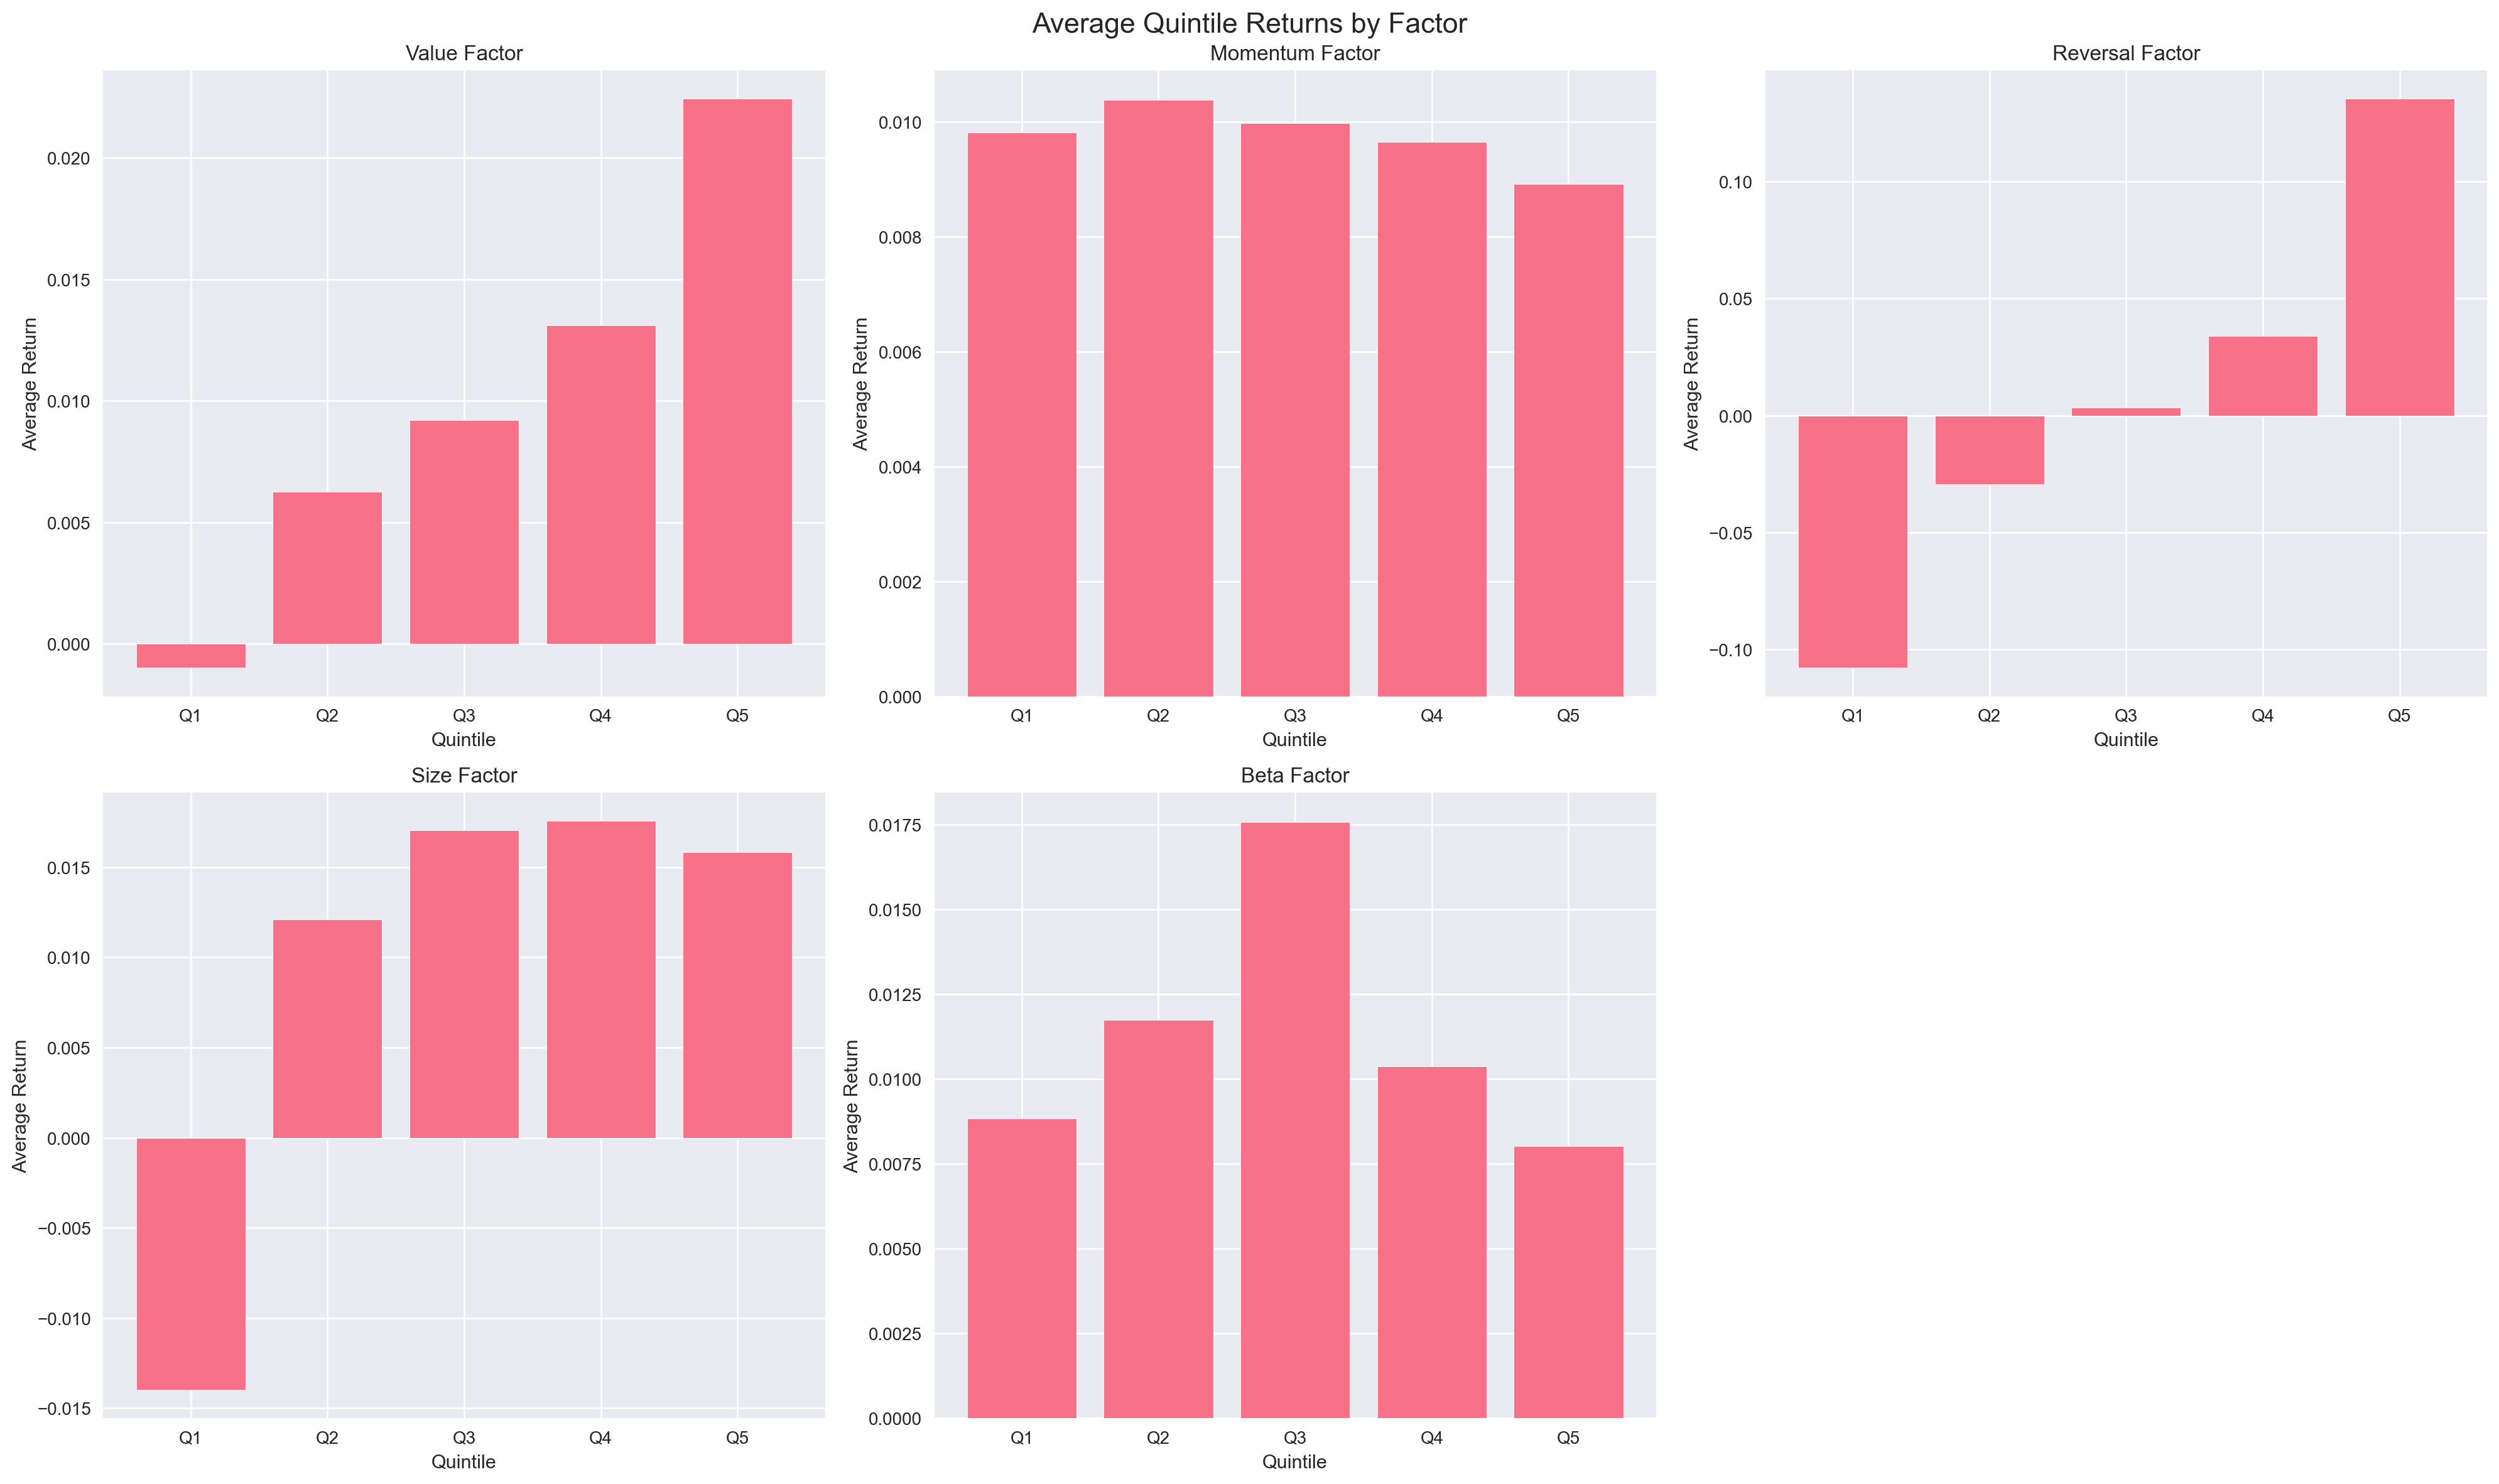

In [348]:
#Set up the plot style
plt.style.use('seaborn')
sns.set_palette("husl")

# Create 2 rows of plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Average Long Only Returns by Quintile per Factor', fontsize=16)
axes_flat = axes.flatten()

# List of dfs
dfs = [
    (value_df, 'Value'),
    (momentum_df, 'Momentum'), 
    (reversal_df, 'Reversal'), 
    (size_df, 'Size'), 
    (beta_df, 'Beta')
]

#plot each df
for i, (df, factor_name) in enumerate(dfs):
    # Select only long only
    quintile_cols = [1, 2, 3, 4, 5]
    
    # Get average returns
    avg_returns = df[quintile_cols].mean()
    axes_flat[i].bar(range(1, 6), avg_returns)
    
    #Labels
    axes_flat[i].set_title(f'{factor_name} Factor')
    axes_flat[i].set_xlabel('Quintile')
    axes_flat[i].set_ylabel('Average Return')
    axes_flat[i].set_xticks(range(1, 6))
    axes_flat[i].set_xticklabels([f'Q{j}' for j in range(1, 6)])

#remove the unused subplot in the second row, adjust layout
fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.savefig('factor_quintile_average_returns.png', dpi=300, bbox_inches='tight')

#plot
plt.show()

### Save the 5 long-short factor returns in a DataFrame called `factors_df`. (Do not drop any missing values). (5 points)

In [344]:
#Compile L/S data
long_short_data = {
    'value': value_df['long_short'],
    'momentum': momentum_df['long_short'],
    'reversal': reversal_df['long_short'],
    'size': size_df['long_short'],
    'beta': beta_df['long_short']
}

# Create a new DataFrame with LS data
factors_df = pd.DataFrame(long_short_data)
print(factors_df.head())

               value  momentum  reversal      size  beta
2008-01-31 -0.019984 -0.011216       NaN -0.008473   NaN
2008-02-29  0.048010 -0.000290  0.278804  0.015915   NaN
2008-03-31  0.006062 -0.007583       NaN  0.080109   NaN
2008-04-30  0.035478  0.031754       NaN  0.084677   NaN
2008-05-30  0.024782 -0.018492  0.282475  0.030354   NaN


In [345]:
# Evaluation cell (used for grading-I don't have a TA)
print(factors_df.head())
factors_df.describe()

               value  momentum  reversal      size  beta
2008-01-31 -0.019984 -0.011216       NaN -0.008473   NaN
2008-02-29  0.048010 -0.000290  0.278804  0.015915   NaN
2008-03-31  0.006062 -0.007583       NaN  0.080109   NaN
2008-04-30  0.035478  0.031754       NaN  0.084677   NaN
2008-05-30  0.024782 -0.018492  0.282475  0.030354   NaN


,value,momentum,reversal,size,beta
count,192.000000,192.000000,87.000000,192.000000,82.000000
mean,0.023419,-0.000894,0.243263,0.029818,-0.000823
std,0.046410,0.034107,0.065918,0.053630,0.007343
min,-0.170952,-0.141938,-0.006824,-0.193110,-0.025952
25%,0.002609,-0.016927,0.206498,0.004121,-0.005531
50%,0.021186,0.000550,0.227912,0.033161,0.000400
75%,0.046231,0.018011,0.278929,0.058263,0.003761
max,0.190675,0.101503,0.493931,0.166313,0.014839


## Evaluate the factors you created (14 points; 4+4+6)

### Estimate Fama-French 5-factor model for the 5 factor portfolios (in `factors_df`). Report the R squares, regression coefficients, and their p values in a single DataFrame called `ff5_factors_reg`. 

### Create `factors_sumstat`. 

In [346]:
# Evaluation cell (used for grading-I don't have a TA)
print(ff5_factors_reg)
print(factors_sumstat)

NameError: name 'ff5_factors_reg' is not defined

### Summarize at least three takeaways related to investments based on your results in Part II so far. Cite credible sources that help explain and support your findings. (6 points)

## Factor combination strategy (‘Mission Impossible’) (8 points)
-  You can get partial credit if you have reasonable code.

In [ ]:
# Evaluation cell (used for grading-I don't have a TA)
impossible_df

In [ ]:
end_time_part2 = time.time()  # End time
execution_time_part2 = end_time_part2 - start_time_part2
# Calculate the number of full minutes
minutes = int(execution_time_part2 // 60)
# Calculate the remaining seconds
seconds = int(execution_time_part2 % 60)  
print(f"Execution time for Part II of the project:{minutes} minutes and {seconds} seconds")